Some packages we'll need below - make sure you have them installed! 

If you use `conda`:

    conda install numpy matplotlib scikit-learn scipy astropy

If you use `pip`:

    pip install numpy matplotlib scikit-learn scipy astropy

In [6]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Density estimation

## 1) Kernel density estimation

Most problems in astronomy (and science?) involve or require estimating an underlying density distribution given some (often noisy) discrete observations. More generally, essentially all statistical inference problems boil down to estimating the probability density over some parameters, or computing integrals over probability densities. When our models are _parametric_, we use algorithms like MCMC to generate samples from density distributions over the parameters in our model. But sometimes we (1) don't have a model, (2) have a parametric but purely numerical model, or (3) want to quickly visualize the density given discrete samples. In these cases we can instead do _non-parametric_ density estimation.

As astronomers, non-parametric density estimation is amongst the first data analysis / visualization skills we learn: We all know and love the histogram!

#### How to astronomy:

1. Discover object / phenomenon
2. Find / create a sample
3. Make histogram
4. ??
5. Profit

The histogram is a great tool for visualization: it is fast, and a standard (people know how to read it). But there are some important caveats that other methods improve on. In particular, the conclusions we draw from looking at a histogram often depend strongly on the choice of bins, both the locations of the bins and the widths of the bins.

For example, let's generate histograms of some 1D point data - in the plots to follow, all of the histograms are made with the same points (variable `x` below), but with different choices for the bin widths and the bin positions:

In [3]:
x1 = np.random.normal(0.25, 0.1, size=200)
x2 = np.random.normal(1., 0.5, size=1000)
x = np.concatenate((x1, x2))
np.random.shuffle(x) # we'll rely on this later!

def true_x_density(x):
    return ((1/6)*norm.pdf(x, loc=0.25, scale=0.1) + 
            (5/6)*norm.pdf(x, loc=1., scale=0.5))

Left-to-right we shift all of the bins at a fixed number of bins, top-to-bottom we change the number of bins:

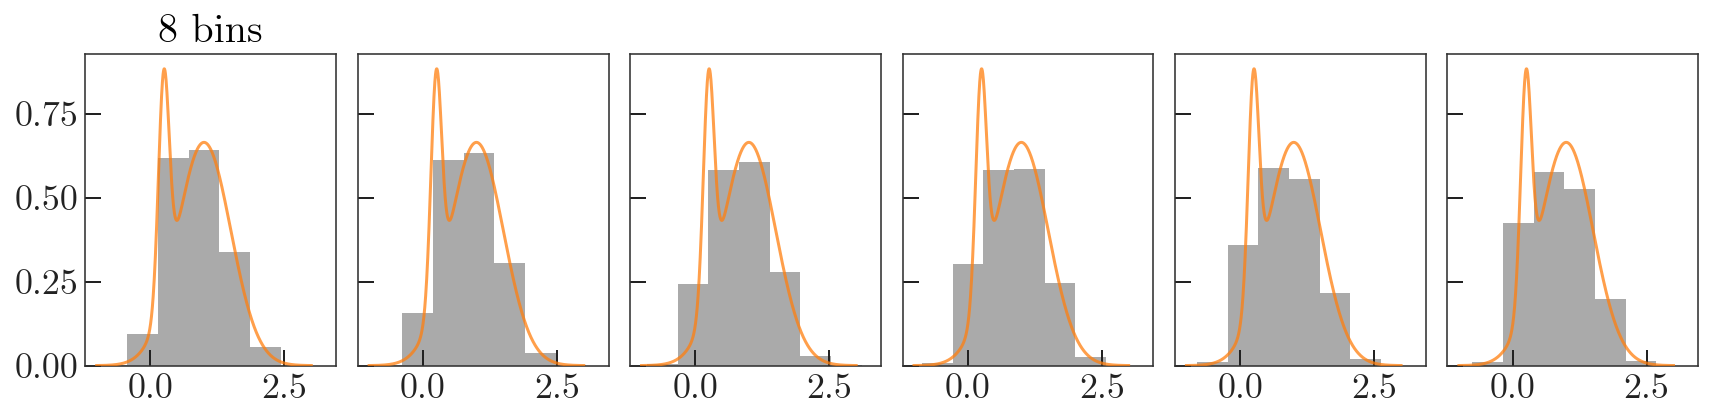

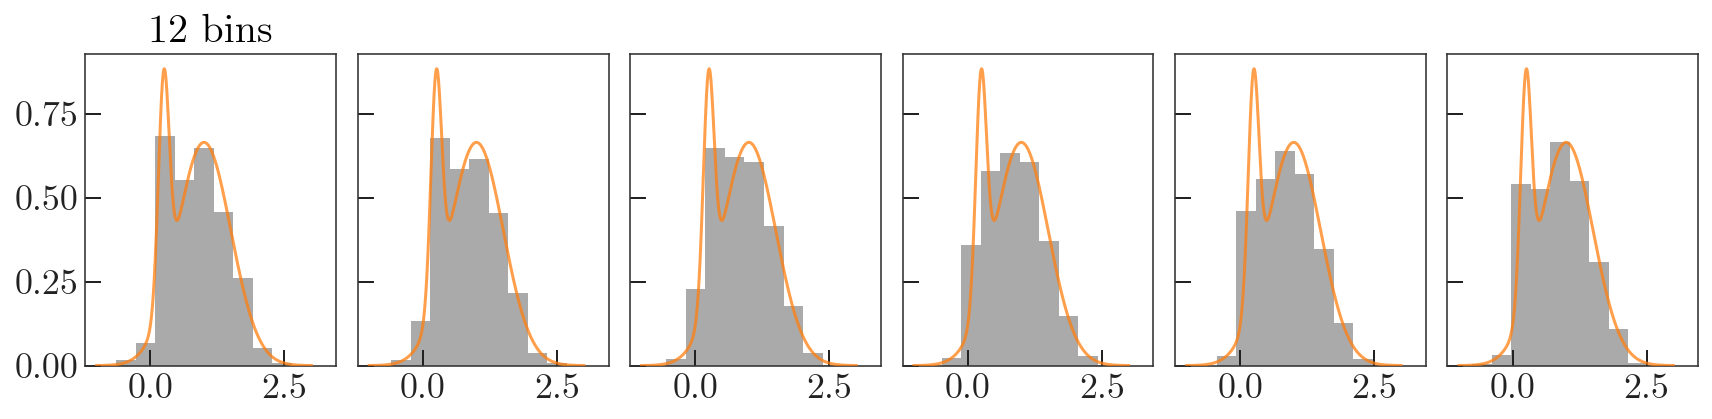

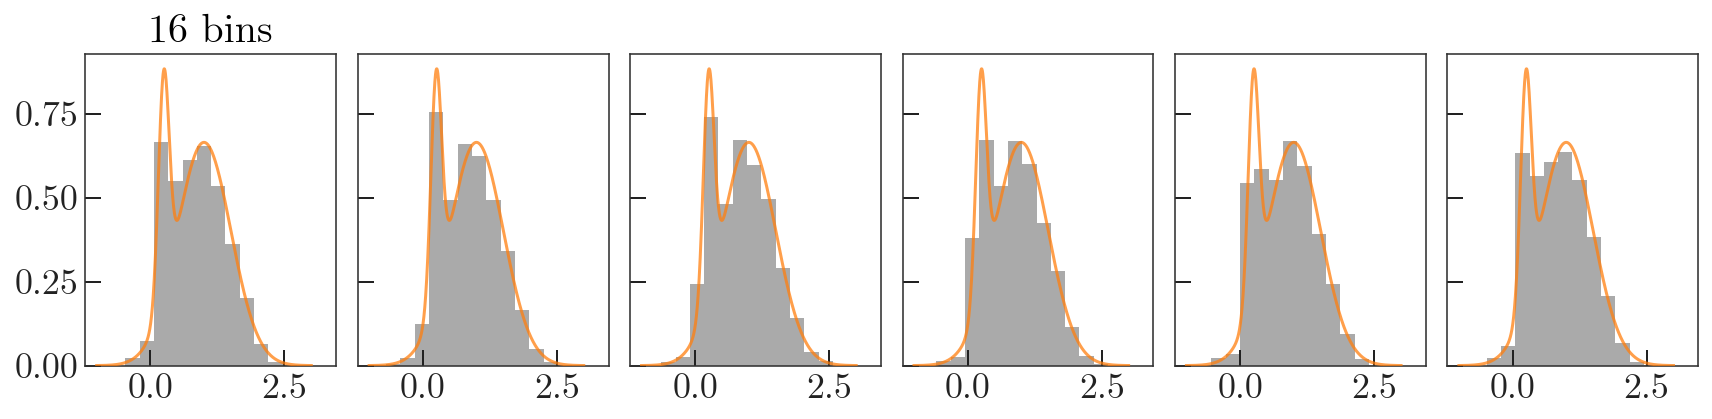

In [4]:
for n_bins in [8, 12, 16]:
    bins = np.linspace(-1, 3, n_bins)

    fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                             sharex=True, sharey=True)
    
    x_grid = np.linspace(-1, 3, 1000)
    for i, ax in enumerate(axes.flat):
        ax.hist(x, bins=bins + i/20, normed=True, color='#aaaaaa')
        ax.plot(x_grid, true_x_density(x_grid), marker='', 
                alpha=0.75, zorder=10, color='tab:orange')
    
    axes[0].set_title('{0} bins'.format(n_bins), fontsize=20)
    fig.tight_layout()

Is the above distribution unimodal or bimodal?

In a histogram, the bin locations and widths are fixed, and the density at the location of each bin is estimated by "moving" data points into each bin and counting. How else could we estimate the density at a location using bins? We could instead fix the bin widths and the data point locations, and move the bin locations to be overlapping and centered on each data point. 

In [5]:
def point_centered_histogram(x, bin_width, data):
    data = np.array(data)
    x = np.array(x)
    y = (data[None] - x[:, None]) / (bin_width/2.)
    return np.sum(np.abs(y) < 1., axis=1) / (len(data) * bin_width)

Let's try this on some trivial data to start before applying it to the point data from above:

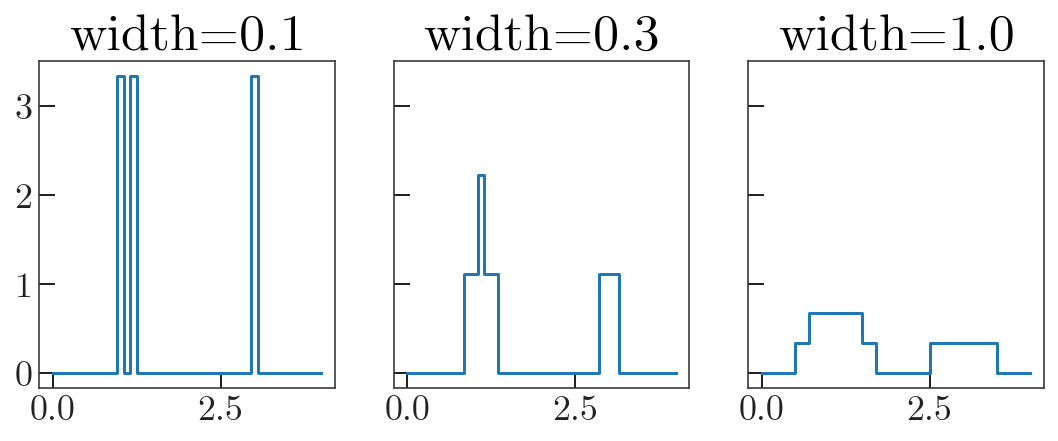

In [6]:
x_grid = np.linspace(0, 4, 512)
data = [1., 1.2, 3.]
bin_widths = [0.1, 0.3, 1.]

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], data), 
            marker='', drawstyle='steps-mid')
    
    ax.set_title('width={0:.1f}'.format(bin_widths[i]))

In the panel on the left, when the bin width is small, we see how our "bins" are now centered on the data themselves. As we increase the bin width (left-to-right), we see that our bins are allowed to overlap. Here we have removed the need to specify bin locations, but we still need to specify the bin width. What we have implemented here is a _kernel density estimation_ of the underlying density, where our kernel is a top-hat function! Let's see how this does with our previous data set:

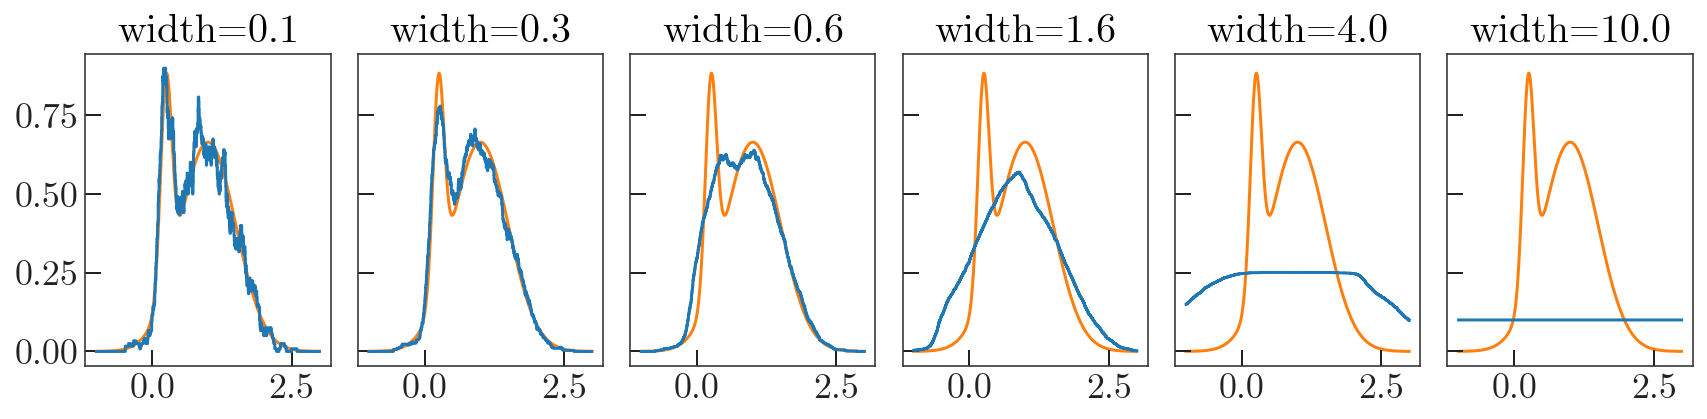

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                         sharex=True, sharey=True)

bin_widths = np.logspace(-1, 1, len(axes))

x_grid = np.linspace(-1, 3, 1024)
for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], x), 
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='')

    ax.set_title('width={0:.1f}'.format(bin_widths[i]), fontsize=20)
fig.tight_layout()

When the bin size is small, the estimated density is very noisy. As we increase the bin width---the half-width is often called the __bandwidth__---small-scale features get washed out (just like in a standard histogram). Somewhere around width=0.3–0.5, the density estimate looks pretty good (true density is plotted in blue)! 

But here's where kernel density estimation gets interesting: The top-hat is just one choice for a kernel function - there are many more we can choose from! In the below, we're going to assume that we're working with 1D data (see other resources for the expressions for higher-dimensional cases). The key idea is the same as above: our density estimate at a given location, $\hat{f}(x)$, given some kernel function $K(z)$ and bandwidth $b$ is computed as

$$
    \hat{f}(x) = \frac{1}{N}\,\frac{1}{h} \, \sum_n^N K\left( \frac{\left|x - x_n\right|}{b} \right)
$$

where the $N$ data points are indexed as $x_n$.

Above, we used the __top-hat kernel__:

$$
    K(z) = \begin{cases}
        1,~{\rm if}~z \leq 1\\
        0,~{\rm else}
        \end{cases}
$$

Other popular choices are the __Gaussian kernel__:

$$
    K(z) = \frac{1}{\sqrt{2\pi}} \, \exp{\left(-\frac{z^2}{2}\right)}
$$

__Epanechnikov kernel__:

$$
    K(z) = \frac{3}{4} \, (1 - z^2)
$$

All of the above kernels are implemented in `scikit-learn`; let's now use `scikit-learn` to build KDE's of the above data using the different kernels, but the same bandwidth:

In [8]:
kde_tophat = KernelDensity(bandwidth=0.2, kernel='tophat')
kde_gauss = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_epan = KernelDensity(bandwidth=0.2, kernel='epanechnikov')
kdes = [kde_tophat, kde_gauss, kde_epan]

In [9]:
X = x.reshape(-1, 1)
for kde in kdes:
    kde.fit(X)

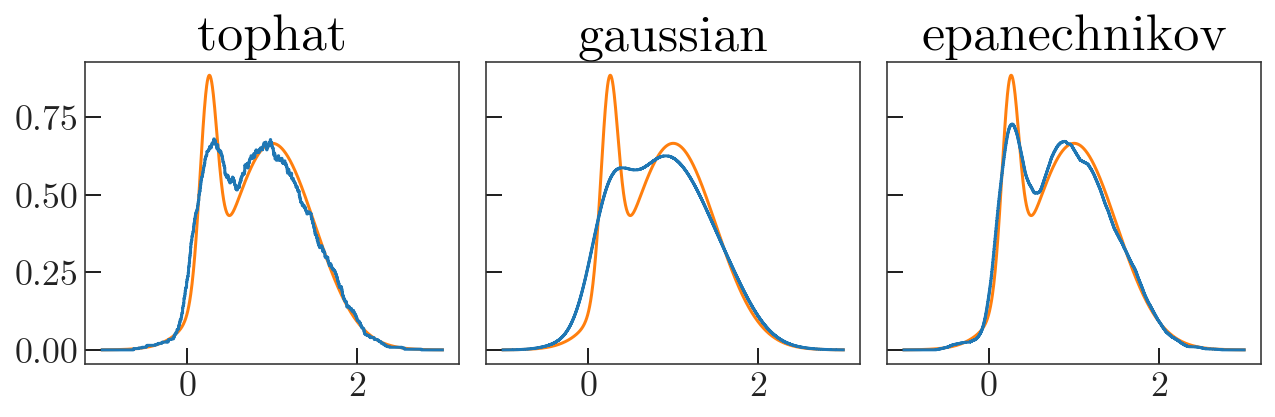

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), 
                         sharex=True, sharey=True)

x_grid = np.linspace(-1, 3, 1024)
for ax, kde in zip(axes.flat, kdes):
    ax.plot(x_grid, np.exp(kde.score_samples(x_grid.reshape(-1, 1))),
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='', color='tab:orange')
    
    ax.set_title(kde.kernel)
    
fig.tight_layout()

Somewhat surprisingly to our intuition (or gut reaction to use Gaussians everywhere), the Gaussian estimate at this bandwidth looks like the worst one! What discriminates the Gaussian kernel from the others here? It has wings to infinity! The Gaussian kernel can perform well in KDE's, but the choice of bandwidth matters a lot.

## Bandwidth selection

With a histogram, we have to specify the bin locations and bin widths. With kernel density estimation, we still have to set the scale length or bandwidth of the kernel. The bandwidth controls how smooth the resulting density estimate will be and therefore has a huge impact on our conclusions. So how do we choose this bandwidth? 

__cross-validation!__ (CV)

In brief: we can hold out some data at random, build the density estimate, compute the likelihood of the held-out data under the KDE, and then optimize the bandwidth using the total likelihood.

In a little more detail: cross-validation is a very general scheme for assessing models. It is generally used in the machine learning community as a way to set hyper-parameters of models. The general idea is to split your data into two groups: a "training set" and a "testing set." We then construct the model using the training set only, and "score" the model by how well it does at predicting or representing the test set. Then we re-generate the train/test set, optimize, and iterate. In the end, we then have to decide how to combine the results into a single model or parameter set. A common choice is to just take the mean of the cross-validation optimized paramter values. 

In order to execute cross-validation, we have to specify a few things:

1. How do we split the data into train/test?
2. How do we score the models?

The answer to each of those questions depends on the problem. Let's think about the problem we have: we have discrete / point data, and we want to estimate the underlying density distribution using KDE. Let's discuss each question separately:

#### How do we split the data into train/test sets?

What are some options?

* _Leave-one-out_: Train on $N-1$ data points, test on remaining data point, iterate through full or part of data set.
* _Leave-K-out_: Same as above, but train on $N-K$ data points and tst on $K$.
* _K-fold_: Split the data into $K$ equal sized chunks, train on concatenated (K-1) chunks, test with the remaining chunk, and iterate through all possible splits.

In the case of density estimation, we have to be conscious of the fact that as we remove data points from the training set (i.e. put them in the test set), or density estimate gets noisier. A conservative thing to do then is Leave-one-out CV. In practice, we have a lot of data points, so we could probably safely do leave-K-our or K-fold cross-validation. But when you have a small dataset, you have to consider these issues!

#### How do we score the models?

The other important consideration for cross-validation is how to score a given parameter choice or model. The "scoring function" is typically called a _loss_ or _cost function_, because we often want to minimize it (the loss or cost). A common choice is the mean-squared error between some test set value $y_n$ and the prediction from the model at that point $\hat{y}_n$: 

$$
{\rm MSE} = \frac{1}{N} \sum_n^N (\hat{y}_n - y_n)^2
$$

For many problems, you might want to try multiple cost functions. In our case, there is an obvious choice: We can use the KDE-computed density (i.e. the likelihood) as the cost function itself (but if we minimize, we have to remember to evaluate the negative-likelihood)!

Let's now do a simple implementation of this cost function and leave-K-out cross-validation:

In [11]:
def cv_neg_ln_likelihood(p):
    ln_b = p[0]
    kde_gauss = KernelDensity(bandwidth=np.exp(ln_b), kernel='gaussian')
    kde_gauss.fit(train_x.reshape(-1, 1))
    return -np.sum(kde_gauss.score_samples(test_x.reshape(-1, 1)))

In our leave-K-out CV, we'll use $K=32$:

In [12]:
bs = []

idx = np.arange(x.size)

# We'll only do 128 iterations, instead of running through the entire dataset!
for i in range(128):
    rand_i = np.random.randint(0, x.size, size=32) # K = 32
    test_x = x[rand_i]
    train_x = x[np.logical_not(np.isin(idx, rand_i))]

    res = minimize(cv_neg_ln_likelihood, x0=-1)
    bs.append(np.exp(res.x[0]))

best_b = np.mean(bs)
best_b

0.08752570748832696

Text(0.5,1,'Gaussian: b = 0.09')

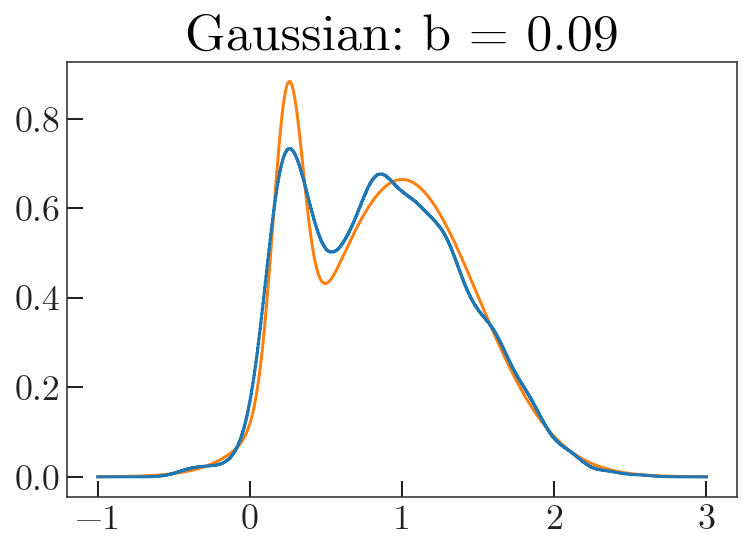

In [19]:
kde_gauss = KernelDensity(bandwidth=best_b, kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:orange')
plt.title('Gaussian: b = {0:.2f}'.format(best_b))

Scikit-learn also has functionality to do CV (via a grid search):

In [15]:
params = {'bandwidth': np.logspace(-3, 1, 128)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(x.reshape(-1, 1))

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([1.00000e-03, 1.07522e-03, ..., 9.30045e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Text(0.5,1,'Gaussian: b = 0.08')

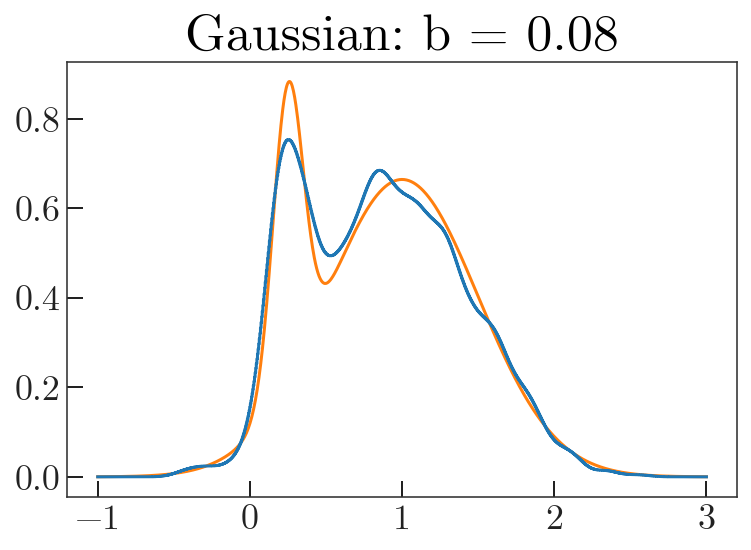

In [20]:
gridsearch_b = grid.best_params_['bandwidth']
kde_gauss = KernelDensity(bandwidth=gridsearch_b, 
                          kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:orange')

plt.title('Gaussian: b = {0:.2f}'.format(gridsearch_b))

## Example / toy problem: 

#### Using density estimation to classify galaxies (KDE + "Naive Bayes")

Let's assume that we've measured very precise distances to a sample of galaxies (i.e. we're going to ignore uncertainties), and our selection function is uniform over the volume. Some of those galaxies lie in a galaxy cluster, others just belong to the field population, and using some other data we have determined labels for the two classes. That is, we know which galaxies are in the cluster, and which are in the field.

In [2]:
# n_cluster = 300
# n_field = 1000
# n_unknown = 100

# dist_cluster = np.random.normal(500., 2., n_cluster)
# dist_field = np.cbrt(np.random.uniform(450**3, 550**3, n_field))
# dist_un_c = np.random.normal(500., 2., n_unknown//2)
# dist_un_f = np.cbrt(np.random.uniform(450**3, 550**3, n_unknown//2))
# all_dist = np.concatenate((dist_cluster, dist_field, dist_un_c, dist_un_f))
# labels = np.array(['cluster']*n_cluster + ['field']*n_field + ['unknown']*n_unknown)

# tbl = Table()
# idx = np.random.choice(len(all_dist), len(all_dist), replace=False)
# tbl['dist'] = all_dist[idx]
# tbl['label'] = labels[idx]
# tbl.write('galaxies.csv', delimiter=',')

In [3]:
tbl = Table.read('galaxies.csv')

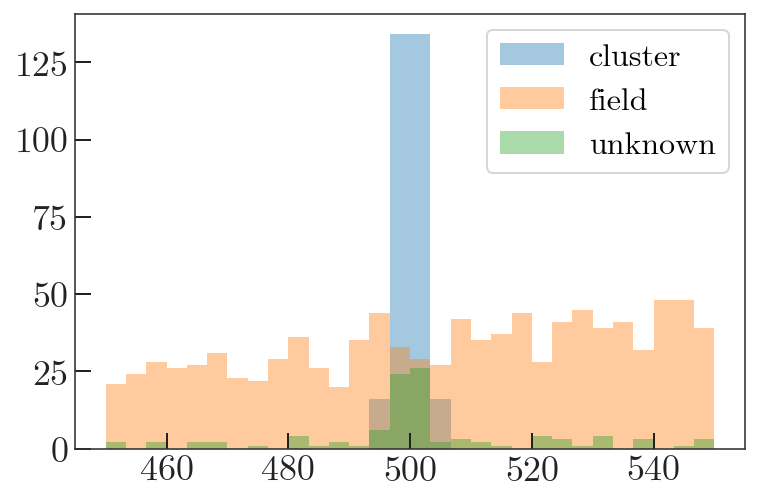

In [4]:
dist_bins = np.linspace(450, 550, 31)

for cls in np.unique(tbl['label']):
    plt.hist(tbl['dist'][tbl['label'] == cls], 
             bins=dist_bins, alpha=0.4, label=cls)
    
plt.legend(fontsize=16)

Let's build density estimates of the "cluster" and "field" populations:

In [16]:
params = {'bandwidth': np.logspace(-3, 1, 128)}

kdes = dict()
for label in ['cluster', 'field']:
    cv = GridSearchCV(KernelDensity(), params)
    cv.fit(tbl['dist'][tbl['label'] == label].reshape(-1, 1))
    
    kdes[label] = KernelDensity(bandwidth=cv.best_params_['bandwidth'])
    kdes[label].fit(tbl['dist'][tbl['label'] == label].reshape(-1, 1))

In [17]:
n_cluster = (tbl['label'] == 'cluster').sum()
n_field = (tbl['label'] == 'field').sum()
print('{0} in cluster, {1} in field'.format(n_cluster, n_field))

weights = dict()
weights['cluster'] = n_cluster / (n_cluster + n_field)
weights['field'] = n_field / (n_cluster + n_field)
weights

300 in cluster, 1000 in field


{'cluster': 0.23076923076923078, 'field': 0.7692307692307693}

In [37]:
unknown = tbl[tbl['label'] == 'unknown']

norm = []
for label in weights.keys():
    ln_likelihoods = kdes[label].score_samples(unknown['dist'].reshape(-1, 1))
    norm = np.sum(weights[label] * np.exp(ln_likelihoods))
norm = np.sum(norm)

In [38]:
prob_field = weights['field'] * np.exp(kdes['field'].score_samples(unknown['dist'].reshape(-1, 1))) / norm
prob_cluster = weights['cluster'] * np.exp(kdes['cluster'].score_samples(unknown['dist'].reshape(-1, 1))) / norm
ratio = prob_cluster / prob_field

In [39]:
unknown_labels = np.full(len(unknown), 'kasdfkjfsaj')
unknown_labels[ratio > 1] = 'cluster'
unknown_labels[ratio <= 1] = 'field'

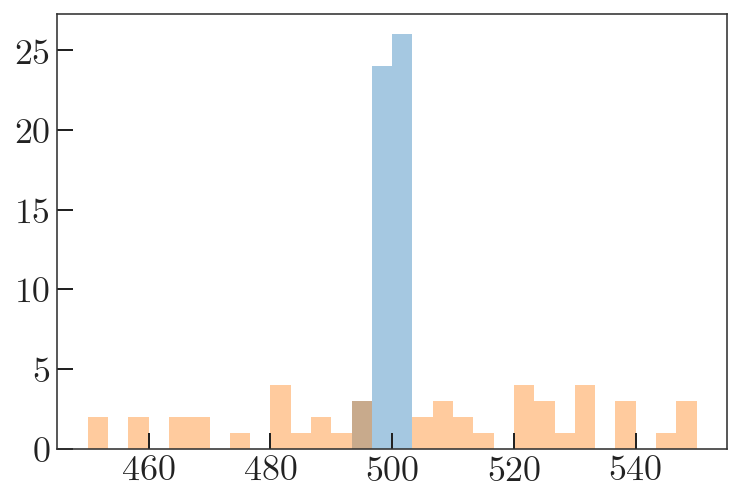

In [40]:
dist_bins = np.linspace(450, 550, 31)

for cls in np.unique(tbl['label']):
    plt.hist(unknown['dist'][unknown_labels == cls], 
             bins=dist_bins, alpha=0.4, label=cls)

## Example from the literature

For stellar stream fitting: [Price-Whelan et al. 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...824..104P/abstract)

In [44]:
import astropy.units as u
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream

In [45]:
w0 = gd.PhaseSpacePosition(pos=[15, 0, 0]*u.kpc,
                           vel=[0, 15, 170.] * u.km/u.s)

potential = gp.MilkyWayPotential()
H = gp.Hamiltonian(potential)

In [46]:
orbit = H.integrate_orbit(w0, dt=0.5, n_steps=3000)

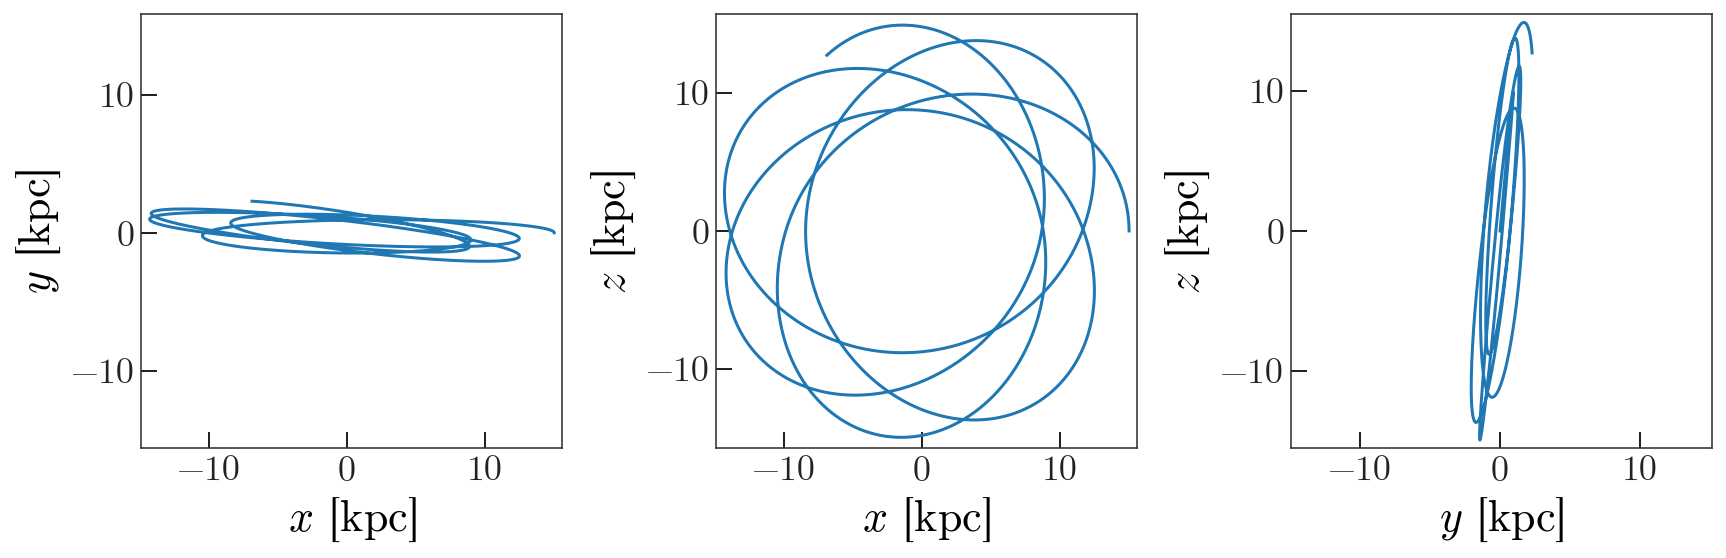

In [47]:
_ = orbit.plot()

In [48]:
stream = fardal_stream(H, orbit, 1E5*u.Msun, release_every=1)

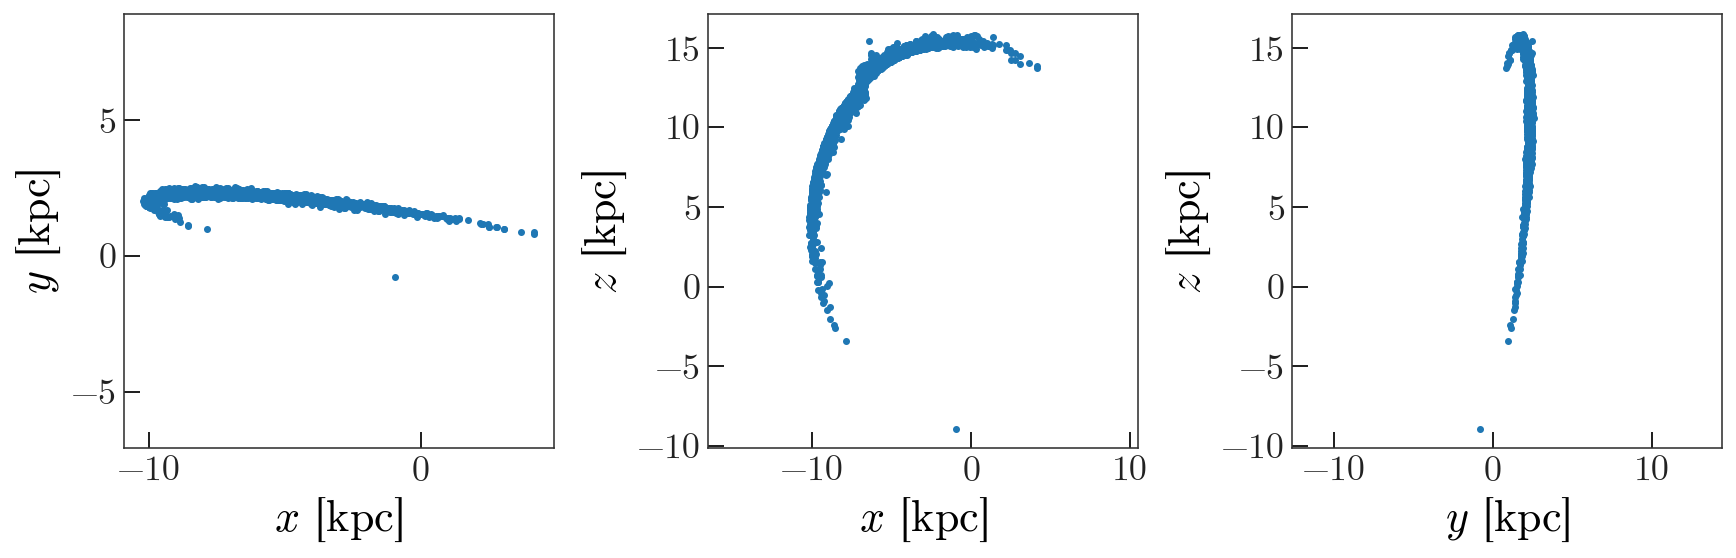

In [49]:
_ = stream.plot()

In [50]:
np.savetxt('stream.csv', stream.pos.xyz.to(u.kpc).value.T)

In [52]:
stream_xyz = np.loadtxt('stream.csv')

array([[-4.45177399,  2.13156688, 14.51659371],
       [-9.57894696,  2.18283046,  7.42238488],
       [ 0.32582606,  1.49567879, 14.91107661],
       ...,
       [-6.79797018,  2.25304168, 12.57609604],
       [-6.97604449,  2.32450802, 12.90910322],
       [-6.73622601,  2.23147994, 12.46310838]])

...motivate GMMs